Group 31

In [3]:
# Load packages
options(warn = -1)
library(dplyr)
library(readr)
library(ggplot2)
library(scales)
library(broom)

# **Section 0: TA Feedback**

- Grade: 27.5 / 30
- Variable description: type for multi and biz should be Boolean or binary.
- Pre-selection of variables: Definitions for attr_index, rest_index, metro_dist are provided in the source link.
- Scientific Question: The question should consider as many input variables as possible.
- Scientific Question and Relevance of EDA: The word "influence" can be misleading. Association vs causation.

###### Sample revisioned assignment 1 content: <mark>Boolean</mark>

# **Section 1: Data Description**

### **1. Descriptive Summary**

The combined Athens Airbnb dataset contains 5280 observations and 20 variables, representing listings collected across both weekdays (2653) and weekends (2627) in Athens. Each record corresponds to a single listing entry with numerical, categorical, and logical attributes describing its characteristics, host behavior, and performance indicators such as price and rating.

| # | Variable Name | Description | Type |
|---|----------------|-------------|------|
| 1 | `realSum` | Total price per booking period (in €) | Float |
| 2 | `room_type` | Type of room (entire home/apartment, private, shared) | Categorical |
| 3 | `room_shared` | Whether the room is shared | Boolean |
| 4 | `room_private` | Whether the room is private | Boolean |
| 5 | `person_capacity` | Maximum guest capacity | Float |
| 6 | `host_is_superhost` | Whether the host is a “superhost” | Boolean |
| 7 | `multi` | Whether the host manages multiple listings | <mark>Boolean</mark> |
| 8 | `biz` | Whether the listing is business-ready | <mark>Boolean</mark> |
| 9 | `cleanliness_rating` | Cleanliness score (1–10) | Float |
| 10 | `guest_satisfaction_overall` | Overall guest satisfaction rating | Float |
| 11 | `bedrooms` | Number of bedrooms | Float |
| 12 | `dist` | Distance from city center (in km) | Float |
| 13 | `metro_dist` | Distance to nearest metro station (in km) | Float |
| 14 | `attr_index` | Attraction proximity index | Float |
| 15 | `rest_index` | Restaurant proximity index | Float |
| 16 | `lng` | Longitude coordinate | Float |
| 17 | `lat` | Latitude coordinate | Float |
| 18 | `realSum_log` | Log-transformed total price | Float |
| 19 | `attr_index_norm` | Normalized attraction index | Float |
| 20 | `day_type` (self added after combination) | weekday/weekend | Categorical |

### **2. Source and Information**

The dataset originates from publicly available Airbnb Athens data compiled for European urban analytics research. Observations are derived from web-scraped listings that include host-provided attributes, review scores, and pricing information.
No missing data were found in the combined dataset — all 5,280 records contain complete values across all 19 variables.  

Source: [Author: Gyódi, Kristóf; Nawaro, Łukasz](https://zenodo.org/records/4446043#.Y9Y9ENJBwUE)  

### **3. Pre-selection of variables**

All 21 variables were imported for exploration; however, some will be excluded from subsequent modelling due to redundancy or irrelevance.  

- `Unnamed: 0` will be dropped — it is an index column with no analytical meaning.  
- Variables such as `room_shared` and `room_private` may be redundant given `room_type`, which already encodes mutually exclusive categories.  
- `attr_index`, `rest_index`, `metro_dist`, `attr_index_norm`, `rest_index_norm` <mark>— engineered location indices and extra distance measures that are likely strongly correlated with `dist`, `lng`, and `lat`; we drop them to avoid multicollinearity and keep location effects easier to interpret. </mark>

The remaining variables, including `realSum`, `room_type`, `person_capacity`, `host_is_superhost`, `multi`, `biz`, `cleanliness_rating`, `guest_satisfaction_overall`, `bedrooms`, `dist`, `lng`, `lat`, and `day_type`.

# **Section 2: Scientific Question**

### 1. **Scientific Question**  
We ask: How does the total price for a two-night stay for two guests in Athens vary across room types, host status, and timing? <mark>Additionally, we examine the relationship between other listing attributes, including capacity, cleanliness, guest satisfaction, number of bedrooms, and location (distance, longitude, and latitude), and accommodation prices.</mark>

### 2. **Response**
The response variable is `realSum` (in EUR), representing the total price for a two-night stay for two guests.  
It captures the main economic outcome we aim to explain through listing characteristics, host attributes <mark>and location.</mark>

### 3. **Focus**
Our primary focus is inference, aiming to understand how price differs <mark>a broad set of listing, host, timing, and location characteristics, with particular interest in room type, Superhost status, and weekday–weekend differences.</mark>  
Prediction remains a secondary goal, as modeling `log(realSum)` can also yield a well-calibrated predictive model while providing interpretable effect estimates such as the weekend premium and Superhost price premium.

# **Section 3: Exploratory Data Analysis and Visualization**

### **1. Data Loading, Cleaning**

In [6]:
# Read datasets
athens_weekdays <- read_csv("athens_weekdays.csv", show_col_types = FALSE)
athens_weekends <- read_csv("athens_weekends.csv", show_col_types = FALSE)

# Read and combine datasets
athens_weekdays <- athens_weekdays %>% 
    mutate(day_type = "Weekday")
athens_weekends <- athens_weekends %>% 
    mutate(day_type = "Weekend")
athens_all <- bind_rows(athens_weekdays, athens_weekends)

# Remove redundant variables
athens_all <- athens_all %>%
  select(-...1,
         -room_shared, -room_private,
         -attr_index, -attr_index_norm,
         -rest_index, -rest_index_norm,
         -metro_dist)

# Check structure
glimpse(athens_all)

New names:
• `` -> `...1`
New names:
• `` -> `...1`


Rows: 5,280
Columns: 13
$ realSum                    <dbl> 129.82448, 138.96375, 156.30492, 91.62702, …
$ room_type                  <chr> "Entire home/apt", "Entire home/apt", "Enti…
$ person_capacity            <dbl> 4, 4, 3, 4, 2, 6, 5, 4, 4, 2, 6, 6, 2, 4, 3…
$ host_is_superhost          <lgl> FALSE, TRUE, TRUE, TRUE, FALSE, TRUE, FALSE…
$ multi                      <dbl> 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0…
$ biz                        <dbl> 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0…
$ cleanliness_rating         <dbl> 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,…
$ guest_satisfaction_overall <dbl> 100, 96, 98, 99, 100, 96, 96, 100, 100, 95,…
$ bedrooms                   <dbl> 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2…
$ dist                       <dbl> 2.8139635, 0.4072929, 1.2372111, 4.3674572,…
$ lng                        <dbl> 23.76600, 23.73168, 23.72200, 23.72712, 23.…
$ lat                        <dbl> 37.98300, 37.97776, 37.97900, 38.01435, 37.…
$ day_type      

### **2. Visualization**

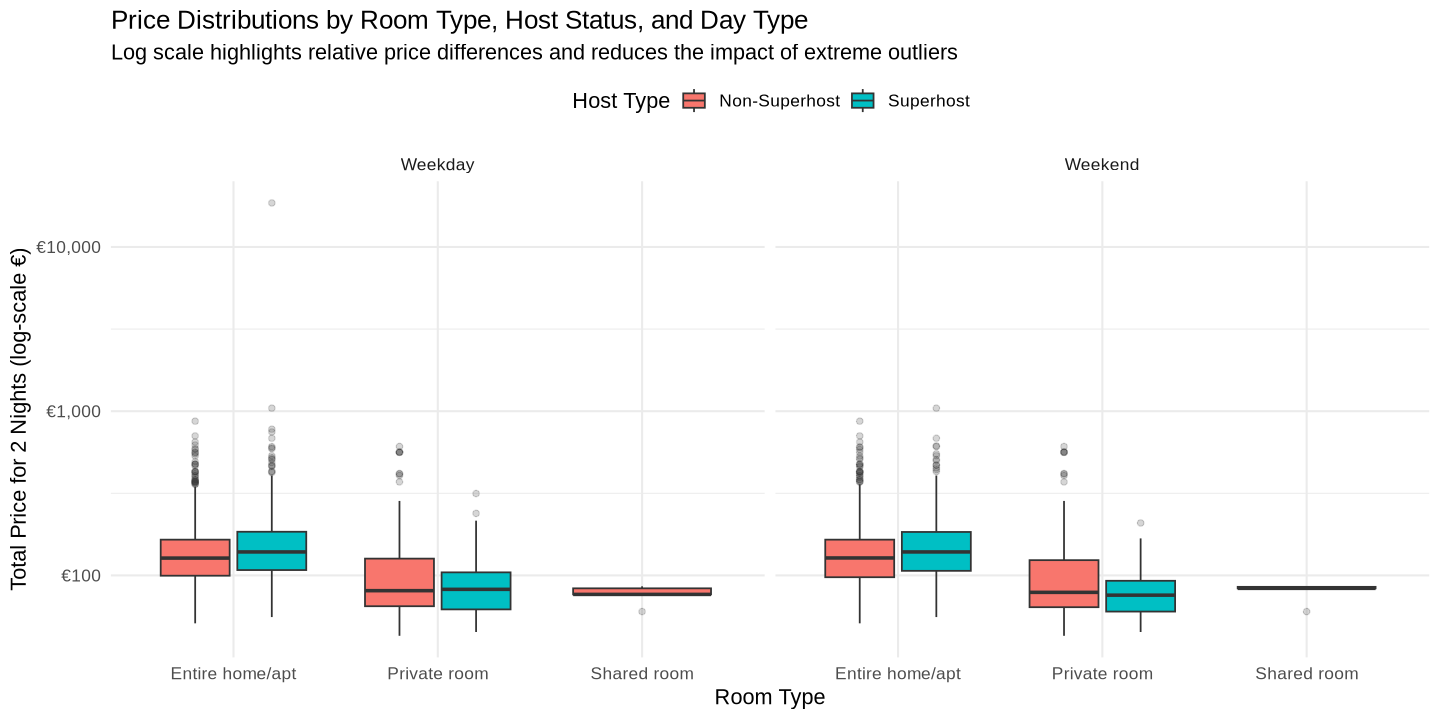

In [5]:
options(repr.plot.width = 12, repr.plot.height = 6)

athens_all %>%
  mutate(
    day_type = factor(day_type, levels = c("Weekday", "Weekend")),
    host_is_superhost = factor(host_is_superhost, labels = c("Non-Superhost", "Superhost"))
  ) %>%
  ggplot(aes(x = room_type, y = realSum, fill = host_is_superhost)) +
  geom_boxplot(outlier.alpha = 0.2) +
  scale_y_log10(labels = label_dollar(prefix = "€")) +
  facet_wrap(~ day_type) +
  labs(
    title = "Price Distributions by Room Type, Host Status, and Day Type",
    subtitle = "Log scale highlights relative price differences and reduces the impact of extreme outliers",
    x = "Room Type",
    y = "Total Price for 2 Nights (log-scale €)",
    fill = "Host Type"
  ) +
  theme_minimal(base_size = 13) +
  theme(legend.position = "top")

**Plot description**  
The figure above shows log-scaled price distributions (`realSum`) across room types, separated by weekday and weekend, and colored by host status (Superhost vs Non-Superhost).

### **3. Interpretation**


- Entire homes/apartments are consistently the most expensive category, while shared rooms are the lowest.  
- Superhosts charge modestly higher median prices, suggesting a reputation premium.  
- Weekend prices are slightly higher than weekday prices across all room types.

**Relevance**  
<mark>This visualization examines the association between price and listing characteristics (`room_type`, `host_is_superhost`) as well as timing (`day_type`), reflecting the main components of our research question.</mark>


**Potential problems**
- Spatial effects: Prices may also depend on geographic location, which isn’t fully captured in this visualization and could confound results.
- Unbalanced group sizes: Shared-room listings are much fewer than entire homes or private rooms, which may lead to unequal variance or influence model weighting.  

# **Section 4: Method and Plan**

### **Proposed Method**

To address our question of how accommodation price (`realSum`) is associated with listing, host, timing, and location characteristics, we propose using a **multiple linear regression model** applied to **log-transformed price** (`log(realSum)`). This method allows us to quantify how price changes across room types, Superhost status, weekday/weekend differences, and other continuous predictors such as cleanliness rating, satisfaction score, bedrooms, capacity, and location.

**Why this method is appropriate**  
- A multiple linear regression on log-price provides interpretable effect estimates and can incorporate both categorical predictors (room type, host status, day type) and continuous predictors (ratings, distance, longitude/latitude). It also aligns with our goal of inference: understanding how price varies with multiple listing characteristics.

**Required assumptions**  
- Linear relationships between predictors and the log-transformed response.
- Normally distributed residuals with constant variance, and independence of observations.
- Assumming no multicollinearity among predictors.

**Potential limitations**  
- The relationship between predictors and price may be nonlinear, and interactions (e.g., between room type and location or Superhost status) may be important but not fully captured in a simple additive model. Outliers or influential listings may still affect estimates even after log transformation. Additionally, unobserved factors such as neighbourhood safety or amenities may introduce omitted-variable bias.


# **Section 5: Computational Code and Output**

In [8]:
# Fit MLR on log-price
model <- lm(log(realSum) ~ room_type + host_is_superhost + day_type + person_capacity + cleanliness_rating + guest_satisfaction_overall +
    bedrooms + dist + lng + lat + multi + biz, data = athens_all)

# Coefficient table
model_results <- tidy(model)
model_results

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),50.8915858028,1.822990e+01,2.79165516,5.262822e-03
room_typePrivate room,-0.2716335901,1.895331e-02,-14.33172317,9.954702e-46
room_typeShared room,-0.4527387827,1.047372e-01,-4.32261495,1.570342e-05
host_is_superhostTRUE,0.0337464745,1.011261e-02,3.33706799,8.525417e-04
day_typeWeekend,0.0008479229,9.509894e-03,0.08916219,9.289564e-01
person_capacity,0.0812366922,5.070010e-03,16.02298547,1.873644e-56
cleanliness_rating,0.0570925469,8.652746e-03,6.59819988,4.570005e-11
guest_satisfaction_overall,0.0011415296,8.754747e-04,1.30389784,1.923254e-01
bedrooms,0.1073858571,9.660737e-03,11.11570005,2.172968e-28


**Interpretation**

The model shows that private and shared rooms are priced significantly lower than entire homes, while Superhost listings command a small premium. Cleanliness, guest satisfaction, and capacity increase the price, whereas distance from the city center strongly reduces it. Weekend effects are negligible after adjusting for other variables. These results align with expectations and indicate that room type and location are the primary drivers of price.

